## Preprocess Data

## Combine Crime Data with Census Datax

In [1]:
# Import libraries 
import pandas as pd
from fuzzywuzzy import process

# Load datasets
crime_df = pd.read_csv('NS_Crime_Stats.csv', encoding='latin1')
census_df = pd.read_csv('98-401-X2021018_English_CSV_data.csv', encoding='latin1')

# Extracting the city name from GEOGRAPHY attribute
crime_df['CITY'] = crime_df['GEOGRAPHY'].str.extract(r'^(.*?)(?:,| \[)')

# Filter the census for selected CHARACTERISTIC_IDs
selected_ids = [2, 4, 6, 35, 36, 37, 39, 40, 318, 302, 335, 1684, 1697, 1999, 2000, 2001]
filtered_census = census_df[census_df['CHARACTERISTIC_ID'].isin(selected_ids)]

# Pivot the census data
pivoted_census = filtered_census.pivot_table(
    index='GEO_NAME',
    columns='CHARACTERISTIC_ID',
    values='C1_COUNT_TOTAL',
    aggfunc='first'
).reset_index()

# Rename census columns for better readability
id_to_name = {
    2: 'total_population',
    4: 'total_private_dwellings',
    6: 'population_density',
    35: 'pct_0_14',
    36: 'pct_15_64',
    37: 'pct_65_plus',
    39: 'avg_age',
    40: 'median_age',
    318: 'median_income',
    302: 'avg_income',
    335: 'low_income_households',
    1684: 'total_visible_minority',
    1697: 'not_visible_minority',
    1999: 'no_diploma',
    2000: 'highschool',
    2001: 'post_secondary'
}
pivoted_census.rename(columns=id_to_name, inplace=True)

# Fuzzy match for only 2021 crime records
crime_2021 = crime_df[crime_df['YEAR'] == 2021].copy()
crime_cities_2021 = crime_2021['CITY'].dropna().unique()
census_names = pivoted_census['GEO_NAME'].tolist()

# Match CITY and GEO_NAME using fuzzy logic (keeping threshold 80)
def fuzzy_match(city, choices, threshold=80):
    match, score = process.extractOne(city, choices)
    return match if score >= threshold else None

# Build mapping
city_to_geo = {city: fuzzy_match(city, census_names) for city in crime_cities_2021}
crime_2021['Matched_GEO_NAME'] = crime_2021['CITY'].map(city_to_geo)

# Merge census data into 2021 crime data
crime_2021_merged = crime_2021.merge(pivoted_census, how='left', left_on='Matched_GEO_NAME', right_on='GEO_NAME')
crime_2021_merged.drop(columns=['GEO_NAME'], inplace=True)

# Combine with rest of crime data (not 2021)
crime_other_years = crime_df[crime_df['YEAR'] != 2021]
final_df = pd.concat([crime_other_years, crime_2021_merged], ignore_index=True)

# Save the merged full dataset
final_df.to_csv('Crime_Full_With_Census.csv', index=False)
print("File saved.")

# References
# https://pypi.org/project/fuzzywuzzy/
# https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html

/opt/anaconda3/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


File saved.


In [5]:
import folium
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv('Crime_Full_With_Census.csv')

# Convert string-based numerics to float
numeric_cols = [
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age', 'avg_income', 'median_income',
    'low_income_households', 'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Features to include
features = [
    'incidents', 'rates', 'Latitude', 'Longitude',
    'total_population', 'total_private_dwellings', 'population_density',
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age',
    'avg_income', 'median_income', 'low_income_households',
    'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

# Filter years and drop rows with missing data
df_filtered = df[df['YEAR'].isin([2021])].dropna(subset=features).copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[features])

KeyError: ['incidents', 'rates', 'Latitude', 'Longitude']

## KMEANS

In [7]:
from sklearn.cluster import KMeans

map_center = [df_filtered['Latitude'].mean(), df_filtered['Longitude'].mean()]
cluster_colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'pink', 'yellow', 'cyan', 'brown', 'lightblue'
] 
# KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=42)
df_filtered['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Evaluate
sil_score_kmeans = silhouette_score(X_scaled, df_filtered['KMeans_Cluster'])
print(f"Silhouette Score (KMeans): {sil_score_kmeans:.2f}")

# Cluster counts
print("KMeans Cluster Counts:")
print(df_filtered['KMeans_Cluster'].value_counts())

# Map
kmeans_map = folium.Map(location=map_center, zoom_start=8)
for _, row in df_filtered.iterrows():
    color = cluster_colors[row['KMeans_Cluster'] % len(cluster_colors)]
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"City: {row['city']}<br>Year: {row['year']}<br>KMeans Cluster: {row['KMeans_Cluster']}"
    ).add_to(kmeans_map)

kmeans_map.save("2021_FINAL_KMEANS_Cluster_MAP.html")
print("🗺️ KMeans crime map saved as '2021_FINAL_KMEANS_Cluster_MAP.html'.")

# Cluster Feature Profiles
kmeans_profiles = df_filtered.groupby("KMeans_Cluster")[features].mean().round(2)
print("🔍 KMeans Cluster Profiles:")
print(kmeans_profiles)

kmeans_profiles.to_csv("2021_FINAL_KMEANS_Cluster_Profiles.csv")


Silhouette Score (KMeans): 0.35
KMeans Cluster Counts:
KMeans_Cluster
0    335
5    223
3    209
2    195
4     83
1     57
6     38
Name: count, dtype: int64
🗺️ KMeans crime map saved as '2021_FINAL_KMEANS_Cluster_MAP.html'.
🔍 KMeans Cluster Profiles:
                incidents   rates  Latitude  Longitude  total_population  \
KMeans_Cluster                                                             
0                    3.20   48.78     45.45     -63.05           4859.11   
1                    0.07    0.00     44.82     -63.13         403131.00   
2                   18.33   88.68     45.66     -61.94           5512.02   
3                    7.19   95.40     44.39     -64.29          13474.18   
4                    7.07  247.95     45.78     -61.35           2087.76   
5                    7.49   46.06     44.64     -65.02           5106.94   
6                   32.95   33.92     46.11     -60.56          94285.00   

                total_private_dwellings  population_density  p

## DBSCAN

In [9]:
from sklearn.cluster import DBSCAN
map_center = [df_filtered['Latitude'].mean(), df_filtered['Longitude'].mean()]
cluster_colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'pink', 'yellow', 'cyan', 'brown', 'lightblue'
]

# DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=5)
df_filtered['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Evaluate silhouette score for valid clusters
valid_dbscan = df_filtered[df_filtered['DBSCAN_Cluster'] != -1]
if valid_dbscan['DBSCAN_Cluster'].nunique() > 1:
    sil_score_db = silhouette_score(
        scaler.transform(valid_dbscan[features]), valid_dbscan['DBSCAN_Cluster']
    )
    print(f"Silhouette Score (DBSCAN): {sil_score_db:.2f}")
else:
    print("Not enough clusters for DBSCAN silhouette score.")

# Cluster counts
print("DBSCAN Cluster Counts:")
print(df_filtered['DBSCAN_Cluster'].value_counts())

# Map
dbscan_map = folium.Map(location=map_center, zoom_start=8)
for _, row in df_filtered.iterrows():
    cid = row['DBSCAN_Cluster']
    color = 'gray' if cid == -1 else cluster_colors[cid % len(cluster_colors)]
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"City: {row['city']}<br>Year: {row['year']}<br>DBSCAN Cluster: {cid}"
    ).add_to(dbscan_map)

dbscan_map.save("2021_FINAL_DBSCAN_Cluster_MAP.html")
print("🗺️ DBSCAN crime map saved as '2021_FINAL_DBSCAN_Cluster_MAP.html'.")

# Cluster Feature Profiles
dbscan_profiles = df_filtered.groupby("DBSCAN_Cluster")[features].mean().round(2)
print("🔍 DBSCAN Cluster Profiles:")
print(dbscan_profiles)

dbscan_profiles.to_csv("2021_FINAL_DBSCAN_Cluster_Profiles.csv")


Silhouette Score (DBSCAN): 0.90
DBSCAN Cluster Counts:
DBSCAN_Cluster
-1     181
 10     49
 17     38
 15     38
 42     38
 19     35
 20     34
 1      33
 38     33
 39     32
 34     32
 32     29
 5      26
 28     19
 27     19
 24     19
 43     19
 22     19
 44     19
 23     19
 47     19
 18     19
 13     19
 2      19
 3      19
 11     19
 7      19
 12     17
 16     16
 46     16
 37     15
 4      15
 31     15
 30     14
 41     14
 40     14
 0      13
 21     13
 9      13
 36     12
 35     12
 33     12
 26     12
 8      11
 29     10
 25     10
 14      9
 6       7
 45      6
Name: count, dtype: int64
🗺️ DBSCAN crime map saved as '2021_FINAL_DBSCAN_Cluster_MAP.html'.
🔍 DBSCAN Cluster Profiles:
                incidents   rates  Latitude  Longitude  total_population  \
DBSCAN_Cluster                                                             
-1                  47.66  414.51     45.12     -63.36          11472.22   
 0                   2.31   23.88     45.83

## HDBSCAN

In [11]:


# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
df_filtered['HDBSCAN_Cluster'] = clusterer.fit_predict(X_scaled)

valid_clusters = df_filtered[df_filtered['HDBSCAN_Cluster'] != -1].copy()
X_valid = scaler.transform(valid_clusters[features])  # re-transform only valid rows

if valid_clusters['HDBSCAN_Cluster'].nunique() > 1:
    sil_score = silhouette_score(X_valid, valid_clusters['HDBSCAN_Cluster'])
    print(f"Silhouette Score (HDBSCAN): {sil_score:.2f}")
else:
    print("Not enough clusters for silhouette score.")

# Cluster counts
print("HDBSCAN Cluster Counts:")
print(df_filtered['HDBSCAN_Cluster'].value_counts())

# 📍 Map
map_center = [df_filtered['Latitude'].mean(), df_filtered['Longitude'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=8)

# Define color palette
cluster_colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'pink', 'yellow', 'cyan', 'brown', 'lightblue'
]
print(f"Total points plotted: {len(df_filtered)}")

# Plot markers
for _, row in df_filtered.iterrows():
    cluster_id = row["HDBSCAN_Cluster"]
    color = 'gray' if cluster_id == -1 else cluster_colors[cluster_id % len(cluster_colors)]

    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"City: {row['city']}<br>Year: {row['year']}<br>Cluster: {cluster_id}"
    ).add_to(crime_map)

# Find top 3 cities by number of incidents
top_cities = df_filtered.sort_values(by='incidents', ascending=False).head(3)

# Add red location markers for top 3 cities
for _, row in top_cities.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        icon=folium.Icon(color='red', icon='info-sign'),
        popup=f"📍Top City: {row['city']}<br>Incidents: {row['incidents']}<br>Cluster: {row['HDBSCAN_Cluster']}"
    ).add_to(crime_map)

# Save map
crime_map.save("2021_FINAL_HDBSCAN_Cluster_MAP.html")

# 📊 Cluster Feature Profiles
cluster_profiles = df_filtered.groupby("HDBSCAN_Cluster")[features].mean().round(2)
print("🔍 Cluster Profiles:")
print(cluster_profiles)

# Optionally save
cluster_profiles.to_csv("2021_FINAL_HDBSCAN_Cluster_Profiles.csv")




Silhouette Score (HDBSCAN): 0.89
HDBSCAN Cluster Counts:
HDBSCAN_Cluster
-1     183
 61     53
 36     38
 0      38
 42     38
      ... 
 79      3
 29      3
 22      3
 18      3
 57      3
Name: count, Length: 85, dtype: int64
Total points plotted: 1140
🔍 Cluster Profiles:
                 incidents   rates  Latitude  Longitude  total_population  \
HDBSCAN_Cluster                                                             
-1                   39.35  367.27     45.05     -63.61           8637.51   
 0                    0.00    0.00     44.65     -63.59         403131.00   
 1                    0.21    0.00     45.16     -62.20         403131.00   
 2                  115.17  118.57     45.96     -60.28          94285.00   
 3                    0.00    0.00     46.12     -60.19           1015.00   
...                    ...     ...       ...        ...               ...   
 79                   2.33   21.69     44.24     -64.98           5866.00   
 80                   3.67  

In [18]:
# Filter years and drop rows with missing data
df_filtered_16 = df[df['year'].isin([2016])].dropna(subset=features).copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered_16[features])

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
df_filtered_16['HDBSCAN_Cluster'] = clusterer.fit_predict(X_scaled)


# Option 1: Reset index and use index positions correctly
valid_clusters = df_filtered_16[df_filtered_16['HDBSCAN_Cluster'] != -1].copy()
X_valid = scaler.transform(valid_clusters[features])  # re-transform only valid rows

if valid_clusters['HDBSCAN_Cluster'].nunique() > 1:
    sil_score = silhouette_score(X_valid, valid_clusters['HDBSCAN_Cluster'])
    print(f"Silhouette Score (HDBSCAN): {sil_score:.2f}")
else:
    print("Not enough clusters for silhouette score.")

# Cluster counts
print("HDBSCAN Cluster Counts:")
print(df_filtered_16['HDBSCAN_Cluster'].value_counts())

# Map
map_center = [df_filtered_16['Latitude'].mean(), df_filtered_16['Longitude'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=8)

# Define color palette
cluster_colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'pink', 'yellow', 'cyan', 'brown', 'lightblue'
]
print(f"Total points plotted: {len(df_filtered_16)}")

# Plot markers
for _, row in df_filtered_16.iterrows():
    cluster_id = row["HDBSCAN_Cluster"]
    color = 'gray' if cluster_id == -1 else cluster_colors[cluster_id % len(cluster_colors)]

    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"City: {row['city']}<br>Year: {row['year']}<br>Cluster: {cluster_id}"
    ).add_to(crime_map)

# Save map
crime_map.save("2016hdbscan_clustering_results.html")
print("HDBSCAN crime map saved as 'hdbscan_clustering_results.html'.")

# Cluster Feature Profiles
cluster_profiles = df_filtered_16.groupby("HDBSCAN_Cluster")[features].mean().round(2)
print("🔍 Cluster Profiles:")
print(cluster_profiles)

# Optionally save
cluster_profiles.to_csv("2016HDBSCAN_Cluster_Profiles.csv")
df_filtered.to_csv("2016_HDBSCAN_Clustered_Data.csv", index=False)


Silhouette Score (HDBSCAN): 0.90
HDBSCAN Cluster Counts:
HDBSCAN_Cluster
-1     171
 56     54
 63     38
 23     38
 42     38
      ... 
 9       3
 71      3
 57      3
 80      3
 49      3
Name: count, Length: 84, dtype: int64
Total points plotted: 1178
HDBSCAN crime map saved as 'hdbscan_clustering_results.html'.
🔍 Cluster Profiles:
                 incidents   rates  Latitude  Longitude  total_population  \
HDBSCAN_Cluster                                                             
-1                   67.37  357.28     44.84     -63.57           55351.8   
 0                    0.00    0.00     45.74     -63.87            1190.0   
 1                    0.00    0.00     45.74     -63.87            1190.0   
 2                    0.00    0.00     46.12     -60.19            1015.0   
 3                    0.00    0.00     45.16     -62.20          403131.0   
...                    ...     ...       ...        ...               ...   
 78                   1.25   15.41     44.1

In [20]:
# Merge clusters from two years on city/location
comparison_df = df_filtered_16[['city', 'HDBSCAN_Cluster']].merge(
    df_filtered[['city', 'HDBSCAN_Cluster']],
    on='city',
    suffixes=('_2016', '_2021')
)

# Check where the cluster assignment changed
comparison_df['changed'] = comparison_df['HDBSCAN_Cluster_2016'] != comparison_df['HDBSCAN_Cluster_2021']
changes = comparison_df[comparison_df['changed'] == True]

print("Cities that changed cluster from 2016 to 2021:")
print(changes)

Cities that changed cluster from 2016 to 2021:
                  city  HDBSCAN_Cluster_2016  HDBSCAN_Cluster_2021  changed
0              Amherst                    26                    23     True
1              Amherst                    26                    23     True
2              Amherst                    26                    23     True
3              Amherst                    26                    23     True
4              Amherst                    26                    -1     True
...                ...                   ...                   ...      ...
26709  Port of Halifax                    21                    74     True
26710  Port of Halifax                    21                    74     True
26711  Port of Halifax                    21                    74     True
26712  Port of Halifax                    21                    74     True
26713  Port of Halifax                    21                    74     True

[23560 rows x 4 columns]


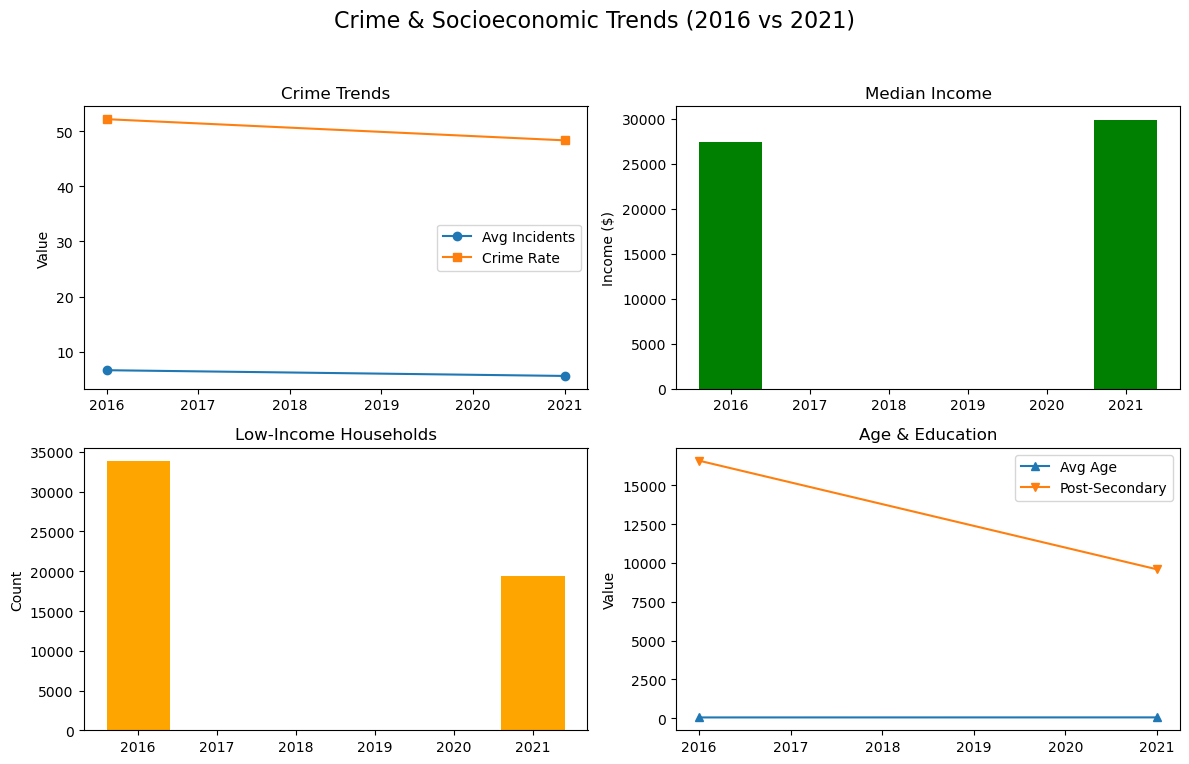

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
df_2016 = pd.read_csv("2016HDBSCAN_Cluster_Profiles.csv")
df_2021 = pd.read_csv("2021HDBSCAN_Cluster_Profiles.csv")

# Add year column
df_2016['year'] = 2016
df_2021['year'] = 2021

# Combine datasets
combined_df = pd.concat([df_2016, df_2021], ignore_index=True)

# Group and calculate averages
trend_summary = combined_df.groupby('year')[
    ['incidents', 'rates', 'median_income', 'post_secondary', 'low_income_households', 'avg_age']
].mean().round(2).reset_index()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Crime & Socioeconomic Trends (2016 vs 2021)", fontsize=16)

# Plot 1: Crime Incidents and Rates
axes[0, 0].plot(trend_summary['year'], trend_summary['incidents'], marker='o', label='Avg Incidents')
axes[0, 0].plot(trend_summary['year'], trend_summary['rates'], marker='s', label='Crime Rate')
axes[0, 0].set_title("Crime Trends")
axes[0, 0].set_ylabel("Value")
axes[0, 0].legend()

# Plot 2: Median Income
axes[0, 1].bar(trend_summary['year'], trend_summary['median_income'], color='green')
axes[0, 1].set_title("Median Income")
axes[0, 1].set_ylabel("Income ($)")

# Plot 3: Low-Income Households
axes[1, 0].bar(trend_summary['year'], trend_summary['low_income_households'], color='orange')
axes[1, 0].set_title("Low-Income Households")
axes[1, 0].set_ylabel("Count")

# Plot 4: Avg Age & Post-Secondary
axes[1, 1].plot(trend_summary['year'], trend_summary['avg_age'], marker='^', label='Avg Age')
axes[1, 1].plot(trend_summary['year'], trend_summary['post_secondary'], marker='v', label='Post-Secondary')
axes[1, 1].set_title("Age & Education")
axes[1, 1].set_ylabel("Value")
axes[1, 1].legend()


plt.savefig("trends.png",  format='png', dpi=300)

# Layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
